# Data Understanding

In [1]:
# Data wrangling
import pandas as pd
# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 280)
import warnings
warnings.filterwarnings("ignore")

In [2]:
!python -m spacy download en_core_web_md

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


You should consider upgrading via the 'C:\Users\Imed\AppData\Local\Programs\Python\Python36\python.exe -m pip install --upgrade pip' command.


In [3]:
# Word processing
import en_core_web_md
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
# Handling of regular expressions
import re

## Dataset identity card

We will have access to a dataset of 10000 tweets that have been hand-categorized by a society (Figure Eight). The tweets are divided into two sets, the training and test sets, which are contained in two csv files.

In [4]:
tweets_df = pd.read_csv("train.csv")

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
tweets_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [7]:
tweets_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Two features have missing values. We will deal with them in Data Preparation phase.

## Field description

The training set contains 7613 samples and 5 features : 
- __id__ is an identification variable
- __keyword__ corresponds to a keyword of the tweet (this field may be empty)
- __location__ gives the place from where the tweet was sent (this variable may not be filled in)
- __text__ is the text contained in the tweet    
- __target__ is the target variable, it is a dichotomous variable that indicates whether a tweet describes a real disaster (`target=1`) or not (`target=0`).

In [8]:
tweets_df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


## Descriptive Statistics
### Target variable

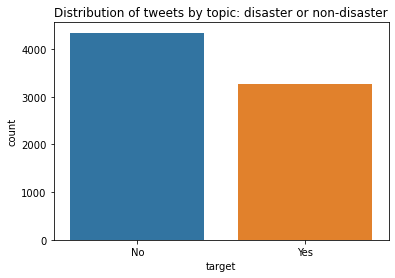

In [9]:
ax = sns.countplot(tweets_df["target"])
ax.set_xticklabels(["No", "Yes"])
ax.set_title("Distribution of tweets by topic: disaster or non-disaster")
plt.show()

In [10]:
tweets_df["target"].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

The dataset is fairly well balanced.

### Qualitative variables

In [11]:
tweets_df[["keyword", "location", "text"]].isnull().sum() / tweets_df.shape[0] * 100

keyword      0.801261
location    33.272035
text         0.000000
dtype: float64

In [12]:
tweets_df[["keyword", "location", "text"]].nunique()

keyword      221
location    3341
text        7503
dtype: int64

In [13]:
tweets_df["keyword"].unique()[:33]

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed'], dtype=object)

In [14]:
tweets_df["text"].head(6)

0                                                                    Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                   Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                        13,000 people receive #wildfires evacuation orders in California 
4                                                 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5                           #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Name: text, dtype: object

As we can see, we will have to make numerous changes to these variables before making statements. in addition, the feature __location__ has too many missing values to be included in our study.

# Data Preparation

## Data Limitation
### Deleting variables

* __id__ is an identifier : it gives no relevant information.
* __location__ has a high rate of missing values (33%), so we remove it.

In [15]:
tweets_df = tweets_df.drop(["id", "location"], axis=1)

In [16]:
tweets_df.head()

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### Deleting records

* We remove missing values from the feature __keyword__ as they do not affect the target variable in terms of proportions.
* The variable __text__ has duplicates. Besides, the values of the target variable may be different in a group of identical observations. We will delete them entirely, in other words we will not keep one sample belonging to a bunch of identical observations. We can do this because it involves very few observations.

In [17]:
tweets_df["target"].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [18]:
tweets_df.loc[tweets_df["keyword"].notnull(), "target"].value_counts(normalize=True)

0    0.572431
1    0.427569
Name: target, dtype: float64

In [19]:
tweets_df = tweets_df.dropna()

In [20]:
tweets_df.isnull().sum()

keyword    0
text       0
target     0
dtype: int64

In [21]:
tweets_df.shape

(7552, 3)

In [22]:
tweets_df.loc[tweets_df["text"].duplicated(False), ["text", "target"]].sort_values(by="text")[:33]

,text,target
4312,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1
4299,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4290,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
6363,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6366,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6373,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6378,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6392,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6377,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
2828,#KCA #VoteJKT48ID 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no iÛ_,1


In [23]:
tweets_df.loc[tweets_df["text"].duplicated(False) == False, "target"].value_counts(normalize=True)

0    0.577678
1    0.422322
Name: target, dtype: float64

In [24]:
tweets_df = tweets_df.drop_duplicates("text", False)

In [25]:
tweets_df.shape

(7383, 3)

## Cleaning
### Variable keyword

A few values of this feature contain a special character sequence, `%20` : this is actually a space. We will proceed to the replacement.

In [26]:
sorted([text for text in tweets_df["keyword"].value_counts().index if text.find('%20') != -1])

['airplane%20accident',
 'blew%20up',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burning%20buildings',
 'bush%20fires',
 'chemical%20emergency',
 'cliff%20fall',
 'dust%20storm',
 'emergency%20plan',
 'emergency%20services',
 'fire%20truck',
 'first%20responders',
 'forest%20fire',
 'forest%20fires',
 'heat%20wave',
 'loud%20bang',
 'mass%20murder',
 'mass%20murderer',
 'natural%20disaster',
 'nuclear%20disaster',
 'nuclear%20reactor',
 'oil%20spill',
 'radiation%20emergency',
 'structural%20failure',
 'suicide%20bomb',
 'suicide%20bomber',
 'suicide%20bombing',
 'violent%20storm',
 'war%20zone',
 'wild%20fires']

In [27]:
tweets_df["keyword"] = tweets_df["keyword"].str.replace('%20', ' ')

In [28]:
[text for text in tweets_df["keyword"].value_counts().index if text.find('%20') != -1]

[]

### Variable text

* In tweets, we can find links to other pages, strings of characters preceded by the `#` or `@` sign to mark a tweet with a keyword or to designate a user.
* Many characters were incorrectly transcribed and some character sequences were added.
* We will remove these character sequences and see if the keyword still belongs to the tweet.

In [29]:
def clean_text(text):
    text = text.replace('\x89Ûª', '\'').replace('\x89Û÷', '\'')
    text = text.replace('\x89ÛÓ', ' ').replace('~', ' ')
    text = text.replace('\x89Û_', '').replace('\x89ÛÏ', '').replace('\x89Û', '').replace('\x9d', '')
    text = text.replace('åÊinåÊ', ' in ')
    text_splitted = text.split("\n")
    items = [re.sub(r"#\w+|@\w+|https?:\/\/[a-zA-Z0-9._=#/%]+|&\w+|w/|/r/\w+|[/\]n|[bft]/|å", "", item, re.MULTILINE)
            for item in text_splitted]
    return " ".join(items)

In [30]:
def contains(text, keyword):
    if text.lower().find(keyword) != -1:
        return 1
    return 0

In [31]:
clean_text("@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO")

' Great atmosphere at the British Lion gig tonight. Hearing is wrecked. '

In [32]:
tweets_df["cleaned_text"] = tweets_df["text"].apply(lambda x : clean_text(x))

In [33]:
tweets_df.tail()

,keyword,text,target,cleaned_text
7578,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both,0,and I wrecked you both
7579,wrecked,Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one,0,Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one
7580,wrecked,#FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM,0,Cramer: Iger's 3 words that wrecked Disney's stock
7581,wrecked,@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO,0,Great atmosphere at the British Lion gig tonight. Hearing is wrecked.
7582,wrecked,Cramer: Iger's 3 words that wrecked Disney's stock - CNBC http://t.co/N6RBnHMTD4,0,Cramer: Iger's 3 words that wrecked Disney's stock - CNBC


In [34]:
contains(tweets_df.loc[7582, "text"], tweets_df.loc[7582, "keyword"])

1

In [35]:
tweets_df["contained_keyword"] = tweets_df[["keyword", "cleaned_text"]].apply(lambda x : contains(x[1], x[0]), axis=1)

In [36]:
tweets_df["contained_keyword"].value_counts()

1    6331
0    1052
Name: contained_keyword, dtype: int64

In [37]:
tweets_df.loc[tweets_df["contained_keyword"] == 0, ["keyword", "text", "cleaned_text"]].tail(10)

,keyword,text,cleaned_text
7352,wildfire,For those impacted by the #CalWildfires here are some great recovery tips to help you in the aftermath http://t.co/wwxbGuBww5,For those impacted by the here are some great recovery tips to help you in the aftermath
7356,wildfire,The Latest: #Wildfire destroys more homes but crews advance - WQOW TV News 18 http://t.co/Hj26SFDdfI,The Latest: destroys more homes but crews advance - WQOW TV News 18
7357,wildfire,#California #wildfire destroys more homes but crews advance. http://t.co/2PPzGpxybi http://t.co/dS9khKffwc,destroys more homes but crews advance.
7385,windstorm,NW Michigan #WindStorm (Sheer) Recovery Updates: Leelanau &amp; Grand Traverse - State of Emergency 2b extended http://t.co/OSKfyj8CK7 #BeSafe,NW Michigan (Sheer) Recovery Updates: Leelanau ; Grand Traverse - State of Emergency 2b extended
7402,wounded,Gunmen open fire on bus near El Salvador's capital killing 4 a week after gang attacks killed 8 bus drivers: http://t.co/Pz56zJSsfT bitÛ_,Gunmen open fire on bus near El Salvador's capital killing 4 a week after gang attacks killed 8 bus drivers: bit
7422,wounded,The Police Chief assured the crowd that this officer-related shooting would be investigated: http://t.co/KMXzhO5TFM. http://t.co/AlBvDNwJtg,The Police Chief assured the crowd that this officer-related shooting would be investigated:
7428,wounded,.@wwp is serving more than 75k veterans. 52k OIF/OEF vets have physical wounds; many more have invisible ones http://t.co/sHHLV4dPlz #client,. is serving more than 75k veterans. 52k OIF/OEF vets have physical wounds; many more have invisible ones
7440,wounds,Acc to the study conducted by SKIMS morethan 50% population in #Kashmir suffer psychiatric disorders http://t.co/sAF9MoSkSN #KashmirConflict,Acc to the study conducted by SKIMS morethan 50% population in suffer psychiatric disorders
7494,wreck,The court system is truly broken indeed! But then its no surprise based on who it's run by! http://t.co/uU64wfg17m,The court system is truly broken indeed! But then its no surprise based on who it's run by!
7558,wrecked,coleslaw #wrecked http://t.co/sijNBmCZIJ,coleslaw


## Word cloud

Now that we have cleaned up the tweets, we can analyse the words used to compose them and try to identify some patterns.

In [38]:
tweets_df.head()

,keyword,text,target,cleaned_text,contained_keyword
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,Wholesale Markets ablaze,1
32,ablaze,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,We always try to bring the heavy.,0
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,: Breaking news:Nigeria flag set ablaze in Aba.,1
34,ablaze,Crying out for more! Set me ablaze,0,Crying out for more! Set me ablaze,1
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE,1


### Taking into account all the tweets

In [39]:
nlp_keyword = en_core_web_md.load()
nlp_text = en_core_web_md.load()

In [40]:
corpus_keyword = " ".join(tweets_df["keyword"].to_list())
corpus_text = " ".join(tweets_df["cleaned_text"].to_list())

In [41]:
len(corpus_keyword), len(corpus_text)

(69356, 589902)

In [42]:
doc_keyword = nlp_keyword(corpus_keyword)
wc_keyword = WordCloud()
cloud_keyword = wc_keyword.generate(doc_keyword.text)

doc_text = nlp_text(corpus_text)
wc_text = WordCloud()
cloud_text = wc_text.generate(doc_text.text)

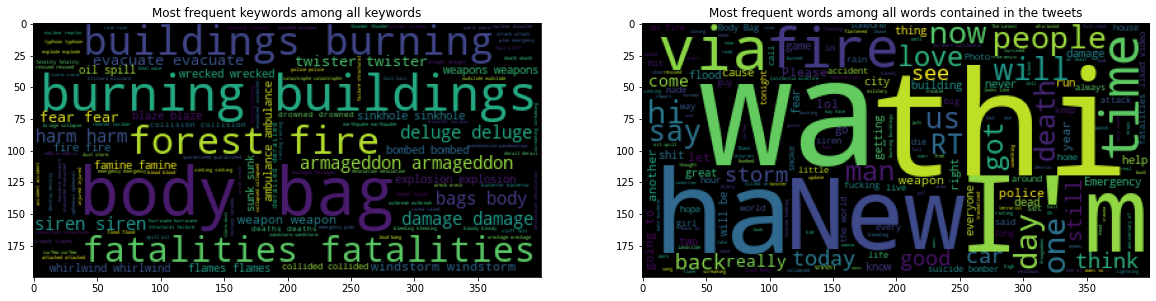

In [43]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.imshow(cloud_keyword)
plt.title("Most frequent keywords among all keywords")

plt.subplot(122)
plt.imshow(cloud_text)
plt.title("Most frequent words among all words contained in the tweets")

plt.show()

As can be seen in the graph on the right, the most present words are words that do not make sense ("ha", "wa", "thi") or are not relevant ("I'm", "via", "will", "got") for determining whether a tweet describes a real or fake disaster. We can remove this kind of words.

In [44]:
STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [45]:
wc_keyword = WordCloud(stopwords=STOP_WORDS)
cloud_keyword = wc_keyword.generate(doc_keyword.text)

wc_text = WordCloud(stopwords=STOP_WORDS)
cloud_text = wc_text.generate(doc_text.text)

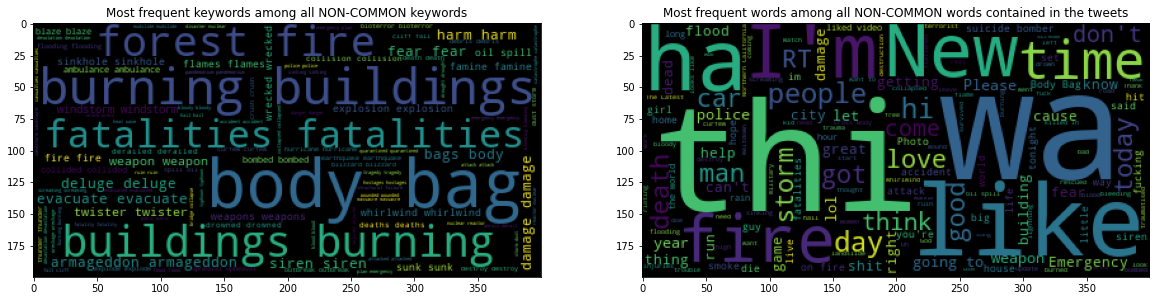

In [46]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.imshow(cloud_keyword)
plt.title("Most frequent keywords among all NON-COMMON keywords")

plt.subplot(122)
plt.imshow(cloud_text)
plt.title("Most frequent words among all NON-COMMON words contained in the tweets")

plt.show()

In [47]:
cloud_text.words_

{'wa': 1.0,
 'thi': 0.9331550802139037,
 'like': 0.6336898395721925,
 'ha': 0.553475935828877,
 "I'm": 0.516042780748663,
 'New': 0.5106951871657754,
 'fire': 0.40641711229946526,
 'time': 0.3689839572192513,
 'people': 0.3502673796791444,
 'hi': 0.34759358288770054,
 'day': 0.339572192513369,
 'love': 0.26737967914438504,
 'man': 0.2620320855614973,
 'RT': 0.25133689839572193,
 'death': 0.24598930481283424,
 'got': 0.24331550802139038,
 'today': 0.23529411764705882,
 'good': 0.22459893048128343,
 'car': 0.21390374331550802,
 'storm': 0.20588235294117646,
 'think': 0.19786096256684493,
 "don't": 0.18983957219251338,
 'come': 0.18716577540106952,
 'weapon': 0.18716577540106952,
 'let': 0.18449197860962566,
 'police': 0.18181818181818182,
 'lol': 0.17914438502673796,
 'year': 0.17379679144385027,
 'Please': 0.1657754010695187,
 'going to': 0.16310160427807488,
 'Emergency': 0.16042780748663102,
 'city': 0.15775401069518716,
 "can't": 0.15775401069518716,
 'dead': 0.15508021390374332,
 'k

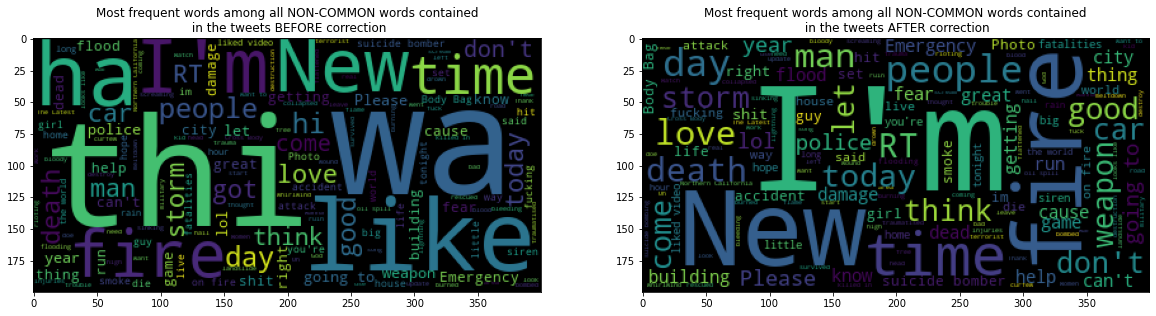

In [48]:
# We need to incorporate the words listed above into the STOP_WORDS set so that they do not affect the visualisation
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.imshow(cloud_text)
plt.title("Most frequent words among all NON-COMMON words contained\n in the tweets BEFORE correction")

cloud_text.stopwords.update(["wa", "ha", "hi", "thi", "got", "like", "I'm", "I 'm", "I' m", "I ' m", "New"])
cloud_text = wc_text.generate(doc_text.text)
plt.subplot(122)
plt.imshow(cloud_text)
plt.title("Most frequent words among all NON-COMMON words contained\n in the tweets AFTER correction")

plt.show()

### Taking into account the target variable

In [49]:
nlp_keyword_target_0 = en_core_web_md.load()
nlp_keyword_target_1 = en_core_web_md.load()
nlp_text_target_0 = en_core_web_md.load()
nlp_text_target_1 = en_core_web_md.load()

In [50]:
corpus_keyword_target_0 = " ".join(tweets_df.loc[tweets_df["target"] == 0, "keyword"].to_list())
corpus_keyword_target_1 = " ".join(tweets_df.loc[tweets_df["target"] == 1, "keyword"].to_list())
corpus_text_target_0 = " ".join(tweets_df.loc[tweets_df["target"] == 0, "cleaned_text"].to_list())
corpus_text_target_1 = " ".join(tweets_df.loc[tweets_df["target"] == 1, "cleaned_text"].to_list())

In [51]:
doc_keyword_target_0 = nlp_keyword_target_0(corpus_keyword_target_0)
wc_keyword_target_0 = WordCloud(stopwords=STOP_WORDS)
cloud_keyword_target_0 = wc_keyword_target_0.generate(doc_keyword_target_0.text)

doc_keyword_target_1 = nlp_keyword_target_1(corpus_keyword_target_1)
wc_keyword_target_1 = WordCloud(stopwords=STOP_WORDS)
cloud_keyword_target_1 = wc_keyword_target_1.generate(doc_keyword_target_1.text)

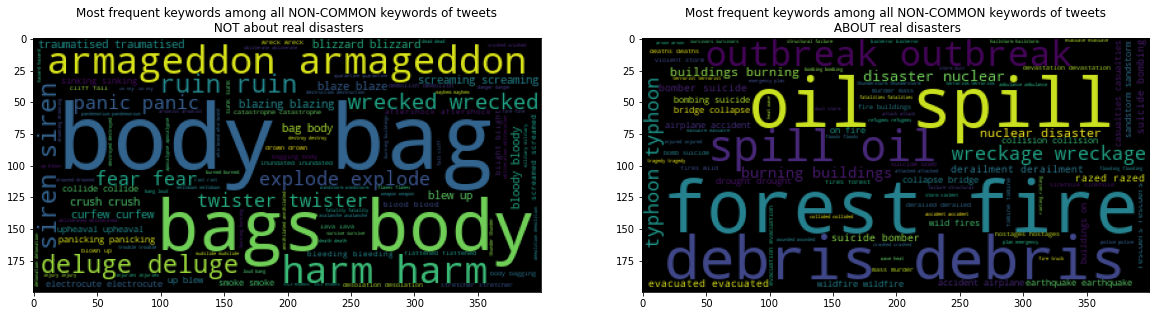

In [52]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.imshow(cloud_keyword_target_0)
plt.title("Most frequent keywords among all NON-COMMON keywords of tweets\n NOT about real disasters")

plt.subplot(122)
plt.imshow(cloud_keyword_target_1)
plt.title("Most frequent keywords among all NON-COMMON keywords of tweets\n ABOUT real disasters")

plt.show()

Comparing the two graphs, we notice that the keywords in the tweets about real disasters are more precise in terms of details : "forest", "fire", "oil", "spill", "debris".

In [53]:
doc_text_target_0 = nlp_text_target_0(corpus_text_target_0)
wc_text_target_0 = WordCloud(stopwords=STOP_WORDS)
cloud_text_target_0 = wc_text_target_0.generate(doc_text_target_0.text)

doc_text_target_1 = nlp_text_target_1(corpus_text_target_1)
wc_text_target_1 = WordCloud(stopwords=STOP_WORDS)
cloud_text_target_1 = wc_text_target_1.generate(doc_text_target_1.text)

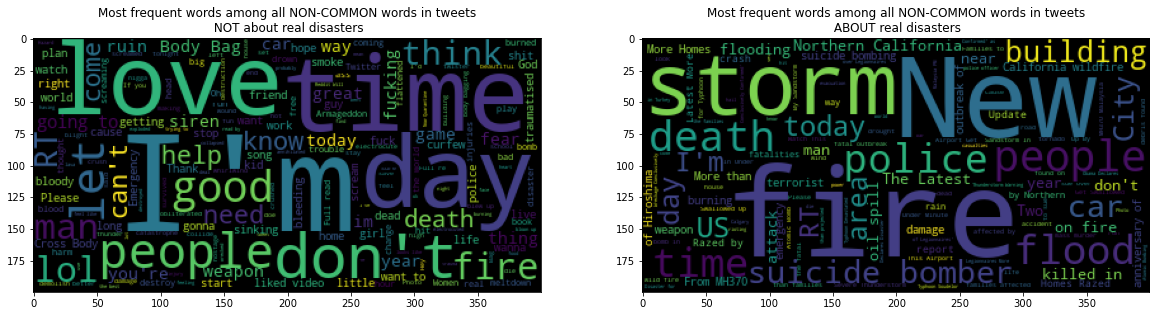

In [54]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.imshow(cloud_text_target_0)
plt.title("Most frequent words among all NON-COMMON words in tweets\n NOT about real disasters")

plt.subplot(122)
plt.imshow(cloud_text_target_1)
plt.title("Most frequent words among all NON-COMMON words in tweets\n ABOUT real disasters")

plt.show()

In [55]:
text_comparison_df = pd.concat([
    pd.DataFrame([cloud_text_target_0.words_.keys(),cloud_text_target_0.words_.values()], index=["words_target_0", "weights_target_0"]).transpose(),
    pd.DataFrame([cloud_text_target_1.words_.keys(),cloud_text_target_1.words_.values()], index=["words_target_1", "weights_target_1"]).transpose()],
    axis=1
)

In [56]:
text_comparison_df.head(10)

,words_target_0,weights_target_0,words_target_1,weights_target_1
0,I'm,1,fire,1
1,time,0.550898,New,0.825688
2,love,0.538922,storm,0.587156
3,day,0.532934,people,0.550459
4,don't,0.437126,death,0.53211
5,people,0.437126,flood,0.504587
6,let,0.419162,time,0.495413
7,good,0.401198,police,0.477064
8,fire,0.377246,suicide bomber,0.46789
9,man,0.353293,car,0.449541


It is more difficult to draw conclusions from the study of the two word clouds.

# Next step : Modeling

We need to export the data for the further process.

In [57]:
tweets_df[["keyword", "cleaned_text", "target"]].to_csv("tweets_train.csv", index=False)